# Instalasi Package

In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install tensorflow

# Import Library

In [ ]:
import zipfile
import os
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Mount Google Drive dan Ekstrak Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/tumor_otak_dataset.zip'

extract_path = '/content/brain_tumor/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))

/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(20).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(22).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(39).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(19).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(80).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(69).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(18).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(100).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(89).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(63).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_tumor/image(4).jpg
/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing/glioma_

# Menggabungkan Dataset

In [ ]:
dataset_paths = [
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_1/Training',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Testing',
    '/content/brain_tumor/tumor_otak_dataset/dataset_2/Training',
]

In [ ]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for cls in classes:
    os.makedirs(os.path.join(combined_dir, cls), exist_ok=True)

for path in dataset_paths:
    for cls in classes:
        src_dir = os.path.join(path, cls)
        dst_dir = os.path.join(combined_dir, cls)
        if os.path.exists(src_dir):
            for fname in os.listdir(src_dir):
                src_file = os.path.join(src_dir, fname)
                dst_file = os.path.join(dst_dir, fname)
                shutil.copy2(src_file, dst_file)

# Visualisasi Sampel Gambar

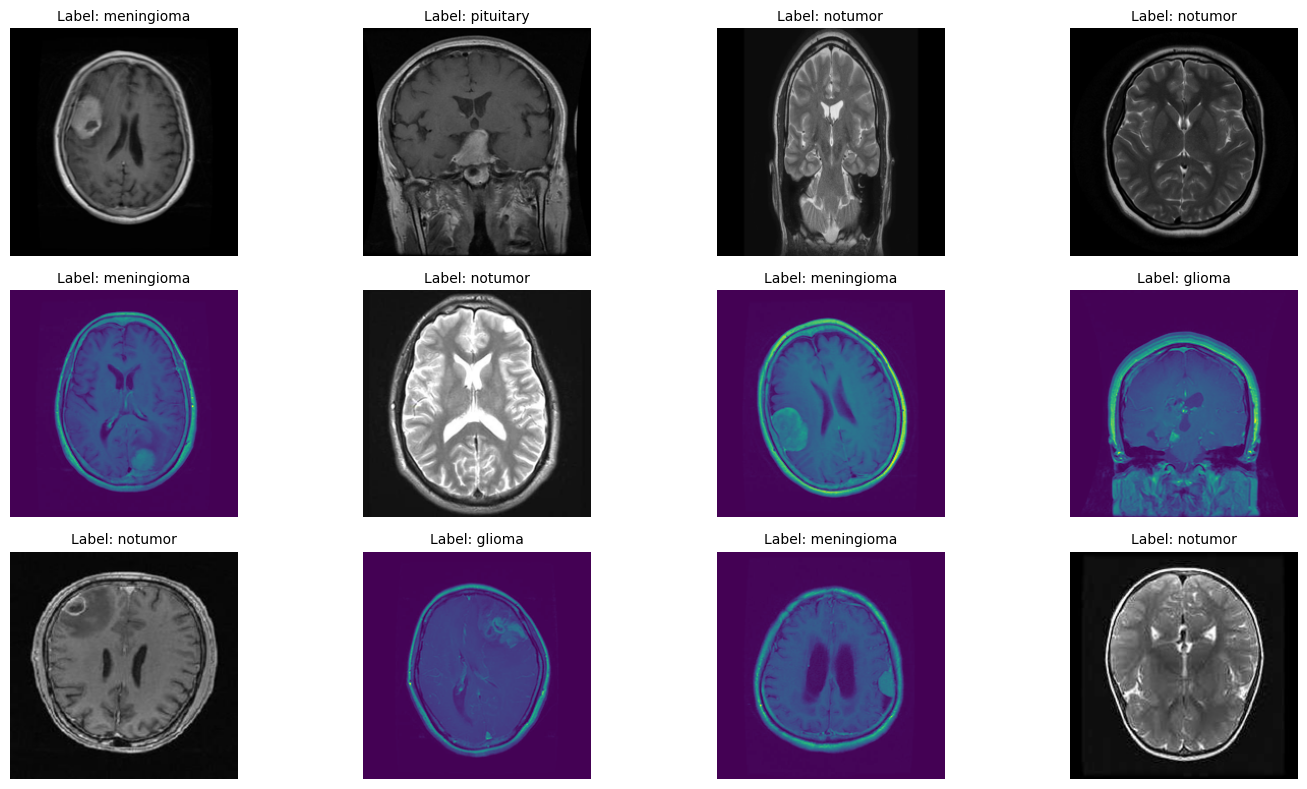

In [ ]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

combined_paths = []
combined_labels = []

for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        combined_paths.append(os.path.join(path, name))
        combined_labels.append(os.path.basename(path))

random_choice = random.sample(range(len(combined_paths)), 12)

fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_choice):
    img_path = combined_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {combined_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

# Statistik Dataset

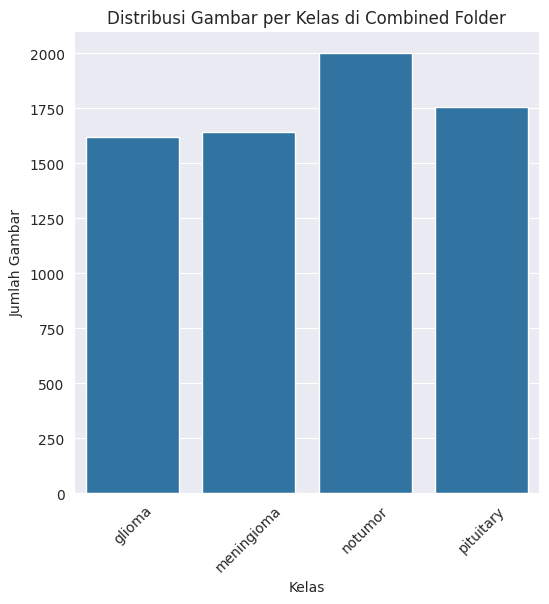

In [ ]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x="label")
plt.title("Distribusi Gambar per Kelas di Combined Folder")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

In [ ]:
distribution_df = pd.DataFrame({'path': combined_paths, 'label': combined_labels})

class_counts = distribution_df['label'].value_counts()
print("Jumlah data per kelas di folder Combined:")
print(class_counts)

Jumlah data per kelas di folder Combined:
label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


# **Split Dataset** - Train, Validation, Test




In [ ]:
combined_dir = '/content/brain_tumor/tumor_otak_dataset/combined'

split_dataset_dir = "/content/brain_tumor/split"
train_dir = os.path.join(split_dataset_dir, "train")
val_dir = os.path.join(split_dataset_dir, "val")
test_dir = os.path.join(split_dataset_dir, "test")

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

val_ratio = 0.2
test_ratio = 0.1

for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    train_val_files, test_files = train_test_split(files, test_size=test_ratio, random_state=42)

    val_size_adjusted = val_ratio / (1 - test_ratio)  # 0.2 / 0.9
    train_files, val_files = train_test_split(train_val_files, test_size=val_size_adjusted, random_state=42)

    def salin(files, destination_dir):
        os.makedirs(os.path.join(destination_dir, class_name), exist_ok=True)
        for file in files:
            src = os.path.join(class_path, file)
            dst = os.path.join(destination_dir, class_name, file)
            shutil.copy2(src, dst)

    salin(train_files, train_dir)
    salin(val_files, val_dir)
    salin(test_files, test_dir)

print("Dataset berhasil dibagi: 70% train, 20% validation, 10% test.")

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dataset_dir, split)
    print(f"\n{split.upper()} SET:")
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        num_images = len(os.listdir(class_path))
        print(f"- {class_name}: {num_images} images")

Dataset berhasil dibagi: 70% train, 20% validation, 10% test.

TRAIN SET:
- glioma: 1134 images
- meningioma: 1151 images
- notumor: 1400 images
- pituitary: 1229 images

VAL SET:
- glioma: 324 images
- meningioma: 329 images
- notumor: 400 images
- pituitary: 352 images

TEST SET:
- glioma: 163 images
- meningioma: 165 images
- notumor: 200 images
- pituitary: 176 images


# Visualisasi Distribusi Data per Split

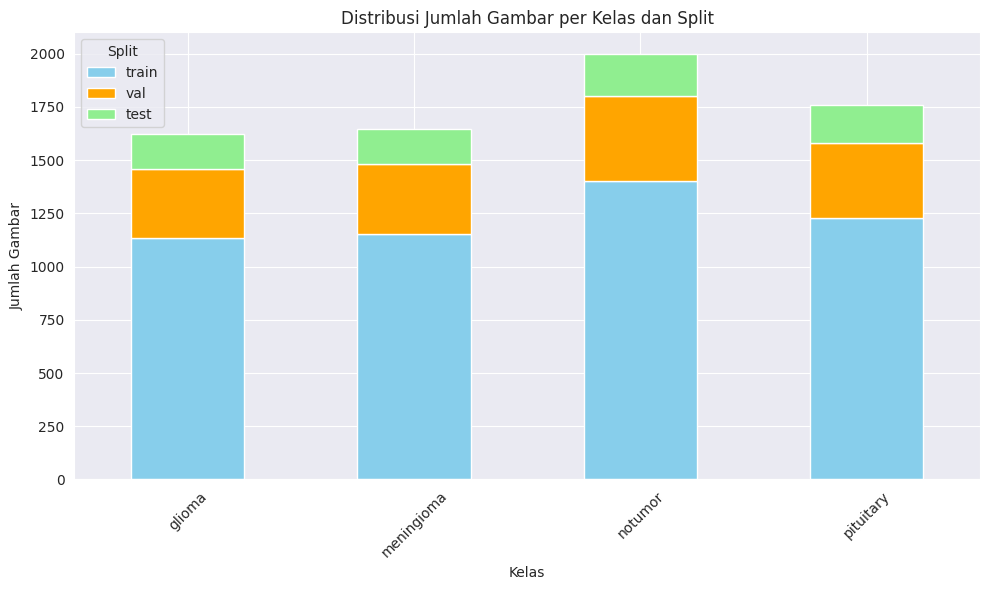

In [ ]:
split_counts = {'train': [], 'val': [], 'test': []}
classes = os.listdir(train_dir)

for split in ['train', 'val', 'test']:
    for class_name in classes:
        path = os.path.join(split_dataset_dir, split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        split_counts[split].append(count)

df = pd.DataFrame(split_counts, index=classes)

df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribusi Jumlah Gambar per Kelas dan Split')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

# Data Augmentation & Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    '/content/brain_tumor/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    '/content/brain_tumor/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4914 images belonging to 4 classes.
Found 1405 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 143s 807ms/step - accuracy: 0.3728 - loss: 1.4640 - val_accuracy: 0.6669 - val_loss: 1.2070 - learning_rate: 1.0000e-04
Epoch 2/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 510ms/step - accuracy: 0.6541 - loss: 0.9076 - val_accuracy: 0.7943 - val_loss: 0.8784 - learning_rate: 1.0000e-04
Epoch 3/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 509ms/step - accuracy: 0.7125 - loss: 0.7809 - val_accuracy: 0.8306 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 4/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 77s 503ms/step - accuracy: 0.7581 - loss: 0.6977 - val_accuracy: 0.8370 - val_loss: 0.5241 - learning_rate: 1.0000e-04
Epoch 5/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 504ms/step - accuracy: 0.7846 - loss: 0.6256 - val_accuracy: 0.8434 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 6/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.7896 - loss: 0.6062 - val_accuracy: 0.8470 - val_loss: 0.4700 - learning_rate: 1.0000e-04
Epoch 7/15
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 5

# Model VGG16 (Transfer Learning)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

# Fine-tuning Model

In [ ]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)

# Visualisasi Training History

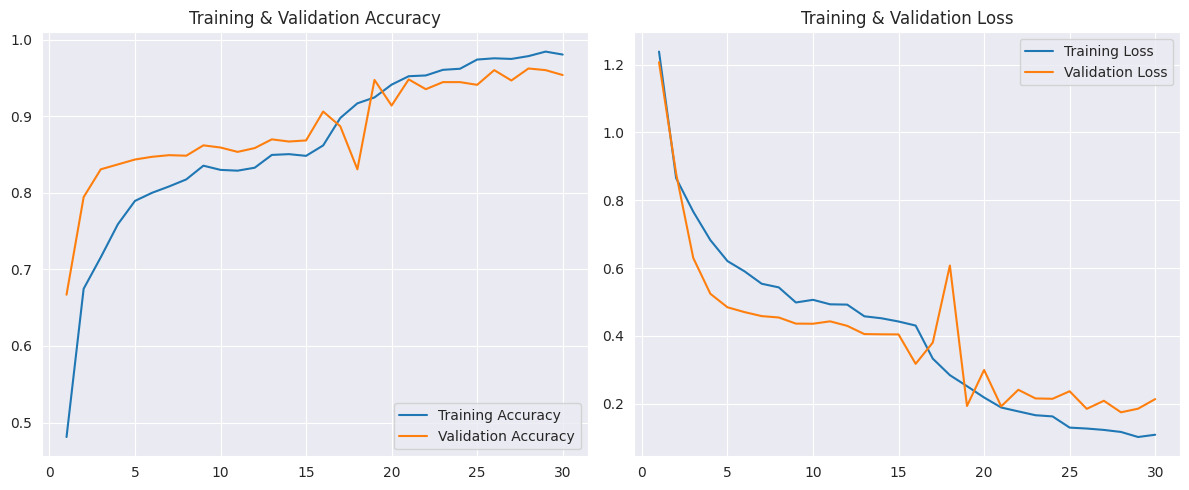

In [ ]:
def plot_training(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training(history, history_fine)

# Evaluasi Model (Data Uji)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/brain_tumor/split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 704 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9459 - loss: 0.2344

Test Accuracy: 96.59%
Test Loss: 0.1713


# Menyimpan dan Menampilkan Evaluasi Akurasi & Loss

In [ ]:
import pandas as pd
results = {
    "Set": ["Training", "Validation", "Testing"],
    "Accuracy": [0.9822, 0.9680, 0.9744],
    "Loss": [0.1165, 0.1427, 0.1359]
}

eval_df = pd.DataFrame(results)
print(eval_df)

          Set  Accuracy    Loss
0    Training    0.9822  0.1165
1  Validation    0.9680  0.1427
2     Testing    0.9744  0.1359


# Confusion Matrix

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step
Class Indices from test_generator: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


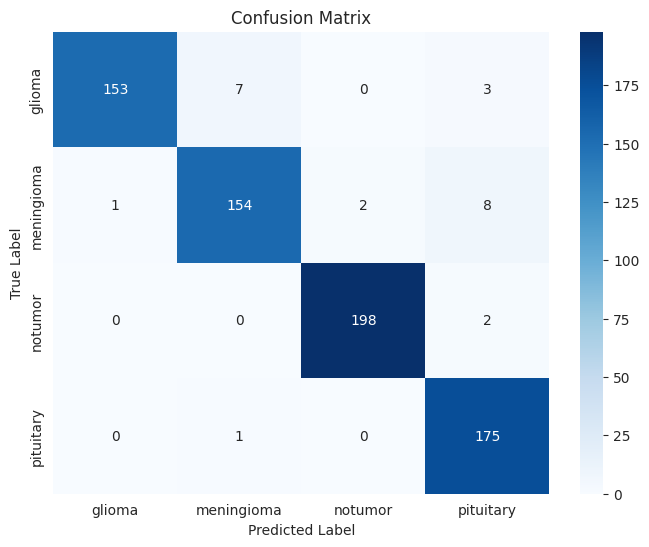

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

y_true = test_generator.classes
y_pred_probabilities = model.predict(test_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print("Class Indices from test_generator:", test_generator.class_indices)

cm = confusion_matrix(y_true, y_pred, labels=list(class_indices.values()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       163
  meningioma       0.95      0.93      0.94       165
     notumor       0.99      0.99      0.99       200
   pituitary       0.93      0.99      0.96       176

    accuracy                           0.97       704
   macro avg       0.97      0.96      0.96       704
weighted avg       0.97      0.97      0.97       704



# Prediksi Gambar Baru

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

IMAGE_SIZE = 224

def predictData(model, class_indices, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    uploaded = files.upload()

    for filename in uploaded.keys():
        img = cv2.imread(filename)
        if img is None:
            print(f"Error: Gagal membaca gambar {filename}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, target_size)
        img_normalized = img_resized / 255.0
        img_expanded = np.expand_dims(img_normalized, axis=0)

        prediction = model.predict(img_expanded)
        predicted_class_idx = np.argmax(prediction)

        idx_to_class = {v: k for k, v in class_indices.items()}
        predicted_class_name = idx_to_class[predicted_class_idx]

        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name}")
        plt.axis('off')
        plt.show()

        print(f"Predicted class: {predicted_class_name}")

In [ ]:
import os

class_names = sorted(os.listdir(train_dir))
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# PITUITARY

Saving Tr-pi_1290.jpg to Tr-pi_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


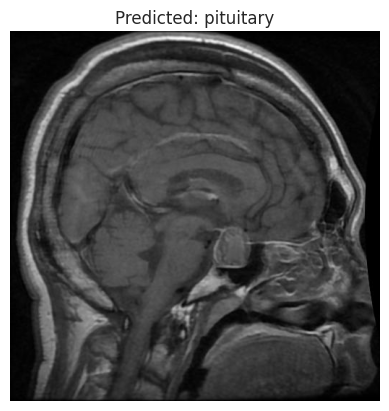

Predicted class: pituitary


In [ ]:
predictData(model, class_to_idx)

Saving Tr-pi_1257.jpg to Tr-pi_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


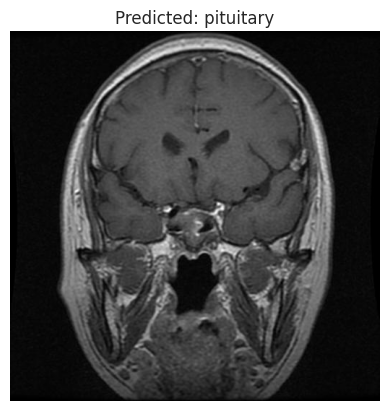

Predicted class: pituitary


In [ ]:
predictData(model, class_to_idx)

Saving Tr-pi_1442.jpg to Tr-pi_1442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


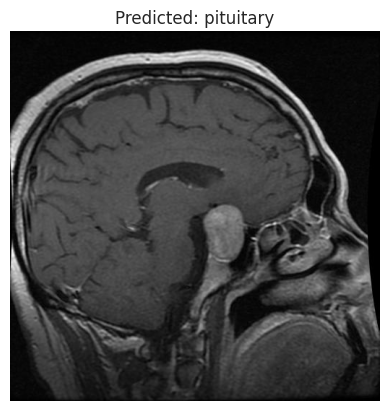

Predicted class: pituitary


In [ ]:
predictData(model, class_to_idx)

Saving Tr-pi_1436.jpg to Tr-pi_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


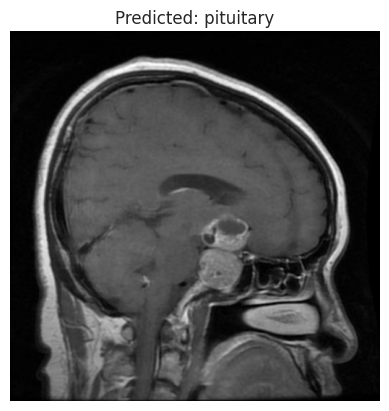

Predicted class: pituitary


In [ ]:
predictData(model, class_to_idx)

Saving Tr-pi_1402.jpg to Tr-pi_1402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


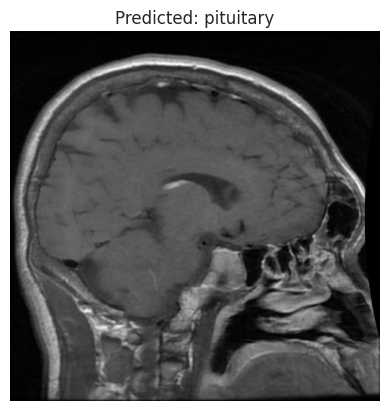

Predicted class: pituitary


In [ ]:
predictData(model, class_to_idx)

# GLIOMA

Saving Te-gl_0200.jpg to Te-gl_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


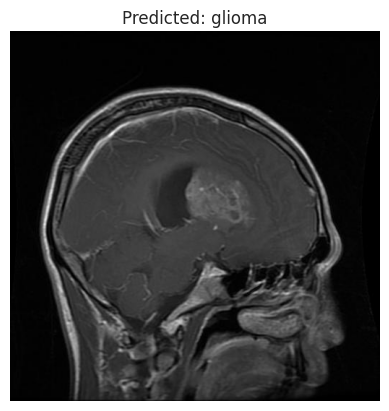

Predicted class: glioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-gl_1039.jpg to Tr-gl_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


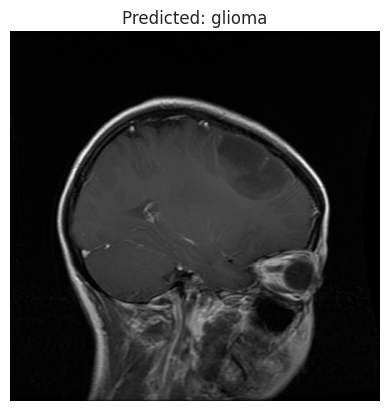

Predicted class: glioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-gl_0887.jpg to Tr-gl_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


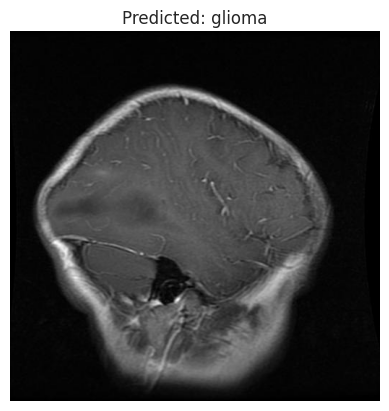

Predicted class: glioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-gl_0082.jpg to Tr-gl_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


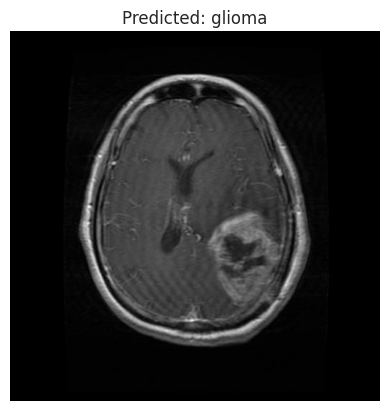

Predicted class: glioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-gl_0662.jpg to Tr-gl_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


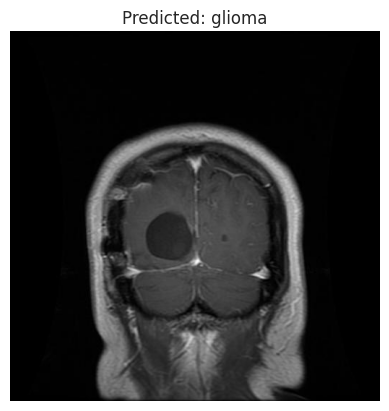

Predicted class: glioma


In [ ]:
predictData(model, class_to_idx)

# MENINGIOMA

Saving Tr-me_0694.jpg to Tr-me_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


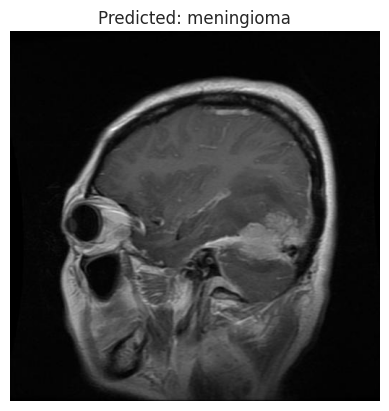

Predicted class: meningioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-me_0714.jpg to Tr-me_0714 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


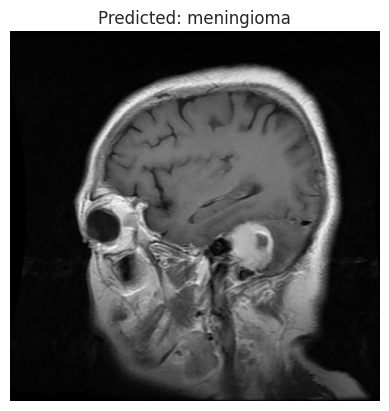

Predicted class: meningioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-me_0862.jpg to Tr-me_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


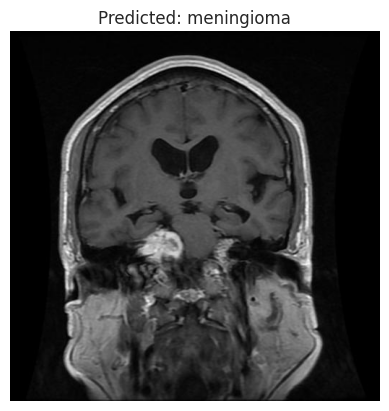

Predicted class: meningioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-me_1058.jpg to Tr-me_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


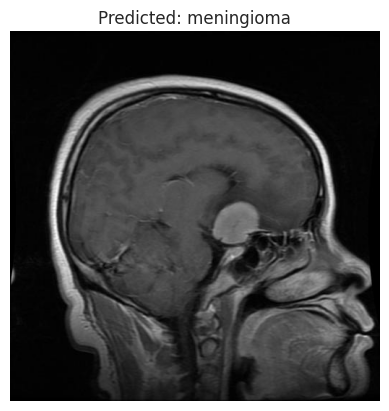

Predicted class: meningioma


In [ ]:
predictData(model, class_to_idx)

Saving Tr-me_1318.jpg to Tr-me_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


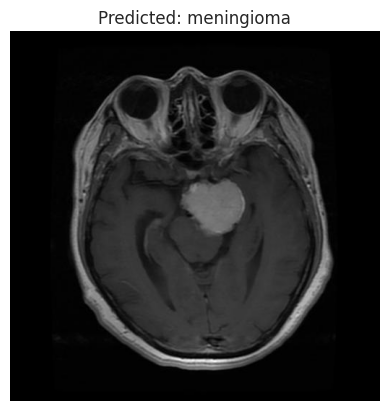

Predicted class: meningioma


In [ ]:
predictData(model, class_to_idx)

# NOTUMOR

Saving Tr-no_1187.jpg to Tr-no_1187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


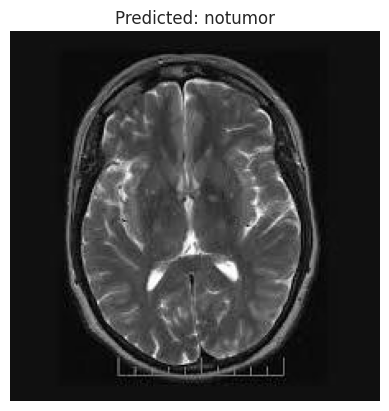

Predicted class: notumor


In [ ]:
predictData(model, class_to_idx)

Saving Tr-no_1248.jpg to Tr-no_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


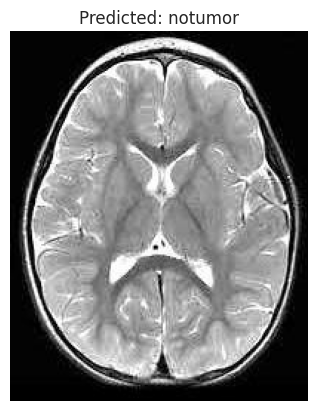

Predicted class: notumor


In [ ]:
predictData(model, class_to_idx)

Saving Tr-no_1388.jpg to Tr-no_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


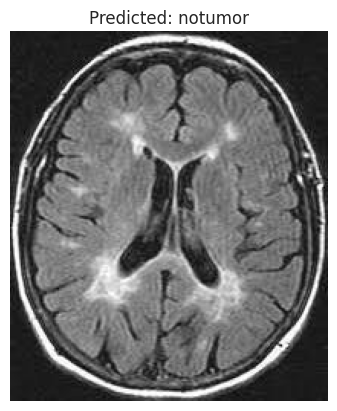

Predicted class: notumor


In [ ]:
predictData(model, class_to_idx)

Saving Tr-no_1497.jpg to Tr-no_1497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


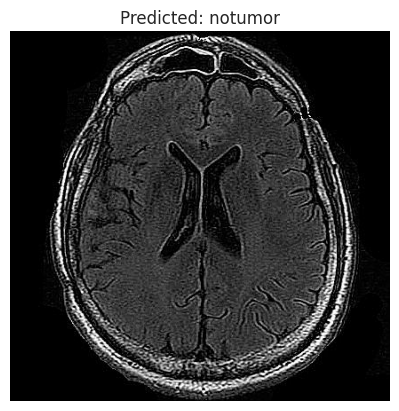

Predicted class: notumor


In [ ]:
predictData(model, class_to_idx)

Saving Tr-no_1536.jpg to Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


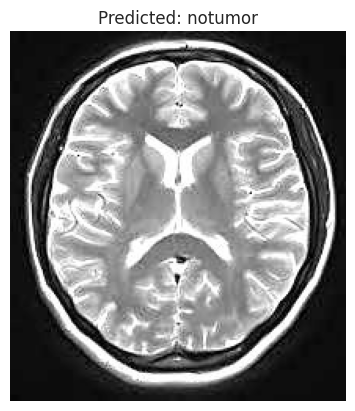

Predicted class: notumor


In [ ]:
predictData(model, class_to_idx)

In [ ]:
model.save('brain_tumor_model.h5')

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model("brain_tumor_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpmwohf8uh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133601943696400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943698512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943696016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943697360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943698896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943689872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943697168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943686800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943690064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943689488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133601943688912